### Problem Statement:
What characteristics of a post on Reddit are most predictive of the overall interaction on a thread (as measured by number of comments)?

We will build a classification model that, using Natural Language Processing and any other relevant features, predicts whether or not a given Reddit post will have above or below the median number of comments.

The models we will utilize are KNN, Logistic Regression, and Random Forest

In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns

from  nltk.stem import PorterStemmer
import spacy

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import (train_test_split, 
                                     cross_val_score, 
                                     StratifiedKFold, 
                                     GridSearchCV)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, 
                              ExtraTreesClassifier, 
                              BaggingClassifier)
from sklearn.metrics import (confusion_matrix, 
                             ConfusionMatrixDisplay, 
                             classification_report)

from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline

import emoji
import unidecode
import re

random.seed(111)

**Importing Datasets**

In [2]:
rel_path_1 = ('datasets/pull_1.csv')
rel_path_2 = ('datasets/pull_2.csv')
rel_path_3 = ('datasets/pull_3.csv')
rel_path_4 = ('datasets/pull_4.csv')
rel_path_5 = ('datasets/pull_5.csv')
rel_path_6 = ('datasets/pull_6.csv')
rel_path_7 = ('datasets/pull_7.csv')

df_1 = pd.read_csv(rel_path_1)
df_2 = pd.read_csv(rel_path_2)
df_3 = pd.read_csv(rel_path_3)
df_4 = pd.read_csv(rel_path_4)
df_5 = pd.read_csv(rel_path_5)
df_6 = pd.read_csv(rel_path_6)
df_7 = pd.read_csv(rel_path_7)

df = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7], ignore_index=True)

**Initial Cleanup**
- Dropping `Unnamed: 0` column
- Dropping any duplicates from `title` column

In [3]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df.drop_duplicates(subset=['title'], keep='last', inplace=True)

In [4]:
df[df.title == '']

,title,num_comments,subreddit,length_time_seconds,length_time_days,created_utc,distinguished,Id,id_from_url,is_original_content,...,stickied,subreddit_subscribers,subreddit_type,total_awards_received,upvote_ratio,whitelist_status,locked,permalink,selftext,url


In [5]:
df.head()

,title,num_comments,subreddit,length_time_seconds,length_time_days,created_utc,distinguished,Id,id_from_url,is_original_content,...,stickied,subreddit_subscribers,subreddit_type,total_awards_received,upvote_ratio,whitelist_status,locked,permalink,selftext,url
0,Cops don't help,922,WhitePeopleTwitter,15512,0,1.653687e+09,NaN,uz8935,<function Submission.id_from_url at 0x7fb379c4...,False,...,False,2536345,public,11,0.94,some_ads,False,/r/WhitePeopleTwitter/comments/uz8935/cops_don...,NaN,https://i.redd.it/hmyphrd963291.jpg
1,Uvalde school police chief identified as comma...,2211,news,16502,0,1.653686e+09,NaN,uz7wjk,<function Submission.id_from_url at 0x7fb379c4...,False,...,False,24719718,public,1,0.97,all_ads,False,/r/news/comments/uz7wjk/uvalde_school_police_c...,NaN,https://www.cnn.com/us/live-news/texas-element...
2,Police didn't immediately confront the gunman ...,1124,nottheonion,15525,0,1.653687e+09,NaN,uz88xi,<function Submission.id_from_url at 0x7fb379c4...,False,...,False,21410253,public,2,0.97,all_ads,False,/r/nottheonion/comments/uz88xi/police_didnt_im...,NaN,https://www.insider.com/texas-shooting-police-...
3,The thin blue line,454,HolUp,15475,0,1.653687e+09,NaN,uz89iz,<function Submission.id_from_url at 0x7fb379c4...,False,...,False,3090734,public,9,0.95,some_ads,False,/r/HolUp/comments/uz89iz/the_thin_blue_line/,NaN,https://i.redd.it/8g06ywgd63291.jpg
4,Customer is upset that a mattress store won’t…...,577,ChoosingBeggars,20426,0,1.653682e+09,NaN,uz6jv0,<function Submission.id_from_url at 0x7fb379c4...,False,...,False,2315698,public,2,0.97,some_ads,False,/r/ChoosingBeggars/comments/uz6jv0/customer_is...,NaN,https://i.redd.it/p1tbj9lnr2291.jpg


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10075 entries, 0 to 10499
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  10075 non-null  object 
 1   num_comments           10075 non-null  int64  
 2   subreddit              10075 non-null  object 
 3   length_time_seconds    10075 non-null  int64  
 4   length_time_days       10075 non-null  int64  
 5   created_utc            10075 non-null  float64
 6   distinguished          13 non-null     object 
 7   Id                     10075 non-null  object 
 8   id_from_url            10075 non-null  object 
 9   is_original_content    10075 non-null  bool   
 10  is_self                10075 non-null  bool   
 11  is_video               10075 non-null  bool   
 12  link_flair_text        5161 non-null   object 
 13  num_crossposts         10075 non-null  int64  
 14  over_18                10075 non-null  bool   
 15  sc

# Creating Classes
Posts with likes above the median will be classified as 1 and below as 0

**Creating ```target```**  1 for posts with ```num_comments``` above median else zero

In [7]:
benchmark = df.num_comments.median()

In [8]:
df['target'] = [1 if num > benchmark else 0 for num in df.num_comments]

In [9]:
df['target'].value_counts(normalize=True)

0    0.503127
1    0.496873
Name: target, dtype: float64

- ```target``` = 0 (not 'hot') is the majority class 

---
---

# Data Cleaning

### Dropping Columns
- Metadata that was scraped but is useless will be dropped in this section of the notebook. 
- Null values are addressed in this section of the notebook

**Dropping:**  ```distinguished```, ```id_from_url```, ```shortlink```, ```url```, ```link_flair_text```, ```selftext```
- These columns all had too many null values to be useful, so they were dropped.

In [10]:
df.drop(labels=['distinguished', 
                'id_from_url', 
                'shortlink', 
                'url', 
                'link_flair_text', 
                'selftext'], 
        axis=1, 
        inplace=True)

**Dropping:**   ```length_time_days```
- No posts were 'hot' for longer than a single day, so this feature is dropped. 

In [11]:
df.drop(labels=['length_time_days'], axis=1, inplace=True)

**Dropping:**  ```stickied```
- Very few posts were "stickied". This feature is not useful so it's being dropped. 

In [12]:
df.stickied.value_counts(normalize=True)

False    0.996328
True     0.003672
Name: stickied, dtype: float64

In [13]:
df.drop(labels=['stickied'], axis=1, inplace=True)

**```whitelist_status``` vs. ```over_18```**

In [14]:
df.whitelist_status.value_counts()

all_ads             7036
no_ads              1303
some_ads            1265
promo_adult_nsfw     150
Name: whitelist_status, dtype: int64

In [15]:
df.over_18.value_counts()

False    9844
True      231
Name: over_18, dtype: int64

In [16]:
df[(df.over_18 == True) & (df.whitelist_status ==  'promo_adult_nsfw')].title.count()

150

In [17]:
df.groupby('over_18')['num_comments'].median()

over_18
False    54.0
True     90.0
Name: num_comments, dtype: float64

''

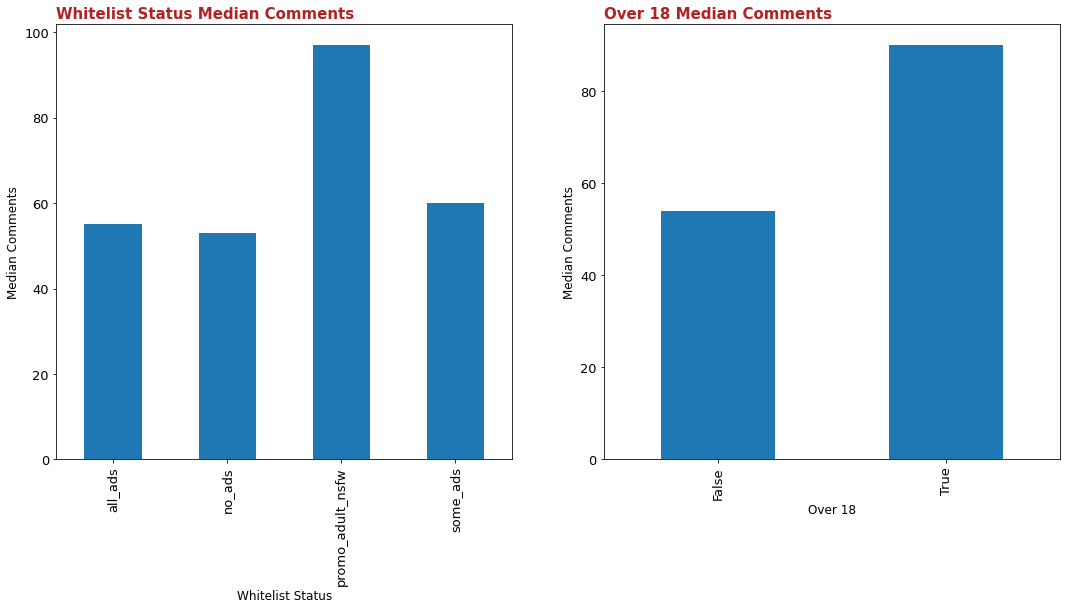

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

df.groupby('whitelist_status')['num_comments'].median().plot(kind = "bar", 
                                                             ax=ax[0], 
                                                             fontsize=13)
ax[0].set_xlabel('Whitelist Status', fontsize=12)
ax[0].set_ylabel('Median Comments', fontsize=12)
ax[0].set_title('Whitelist Status Median Comments', fontsize=15, 
                fontweight='bold', color='firebrick', loc='left')

df.groupby('over_18')['num_comments'].median().plot(kind = "bar", 
                                                    ax=ax[1], 
                                                    fontsize=13)
ax[1].set_xlabel('Over 18', fontsize=12)
ax[1].set_ylabel('Median Comments', fontsize=12)
ax[1].set_title('Over 18 Median Comments', fontsize=15, 
                fontweight='bold', color='firebrick', loc='left')
;

In [19]:
df.drop(columns='whitelist_status', axis=1, inplace=True)

**```whitelist_status``` vs. ```over_18```**
- These features are related. All 112 posts with "promo_adult_nsfw" are listed as "over_18"
- ```whitelist_status``` has fewer posts in the aforementioned category than ```over_18```
- All other groups in ```whitelist_status``` have similar means 
- Because of these observations, ```whitelist_status``` is being dropped

**Dropping `subreddit_type`**
- Only 33 out of 10000 were restricted. This will not be a useful feature

In [20]:
df.subreddit_type.value_counts()

public        10042
restricted       33
Name: subreddit_type, dtype: int64

## Addressing Outliers

**Target Outliers**
- In order to reduce the skew of our target, we removed ___ Rows from that had ```num_comments``` above 1200
- These posts were extreme outliers. This is only 2% of our dataset. 
- Our median nearly the same. 
- These posts most likely had other misleading features that could make our model less accurate. 

In [22]:
print(df.shape)
print(df[df.num_comments > 1200].title.count())

(10075, 20)
204


In [23]:
df.drop(index=df[df.num_comments > 1200].index, inplace=True)
df.reset_index(drop=True, inplace=True)

**`score`**
- there are 4 posts with scores over 100,000. We will drop these outliers to reduce the skew of the distribution 

In [24]:
df.drop(index=df[df.score > 100000].index, inplace=True)
df.reset_index(drop=True, inplace=True)

---
---

# Exploratory Data Analysis

In [25]:
# Function to plot nominal_feature

def plot_nominal_feature(feature):    
    fig, ax = plt.subplots(3, 1, figsize=(16, 18))

# Bar chart showing nominal_features dist

    ax[0].bar(x = [str(num) for num in sorted(df[feature].unique())], 
              height = df[feature].value_counts(normalize=True).sort_index())
    ax[0].set_ylabel('Proportion of ' + feature, fontsize=13)
    ax[0].set_title('Proportion of Each ' + feature, 
                    fontweight='bold', 
                    color='firebrick', 
                    pad=18, 
                    loc='left')

# Bar chart showing SalePrice dist for unique() values of feature

    ax[1].bar(x = [str(num) for num in sorted(df[feature].unique())], 
              height = df.groupby([feature])['num_comments'].median())
    ax[1].set_ylabel('Median Num Comments', fontsize=13)
    ax[1].set_title('Median Num Comments for ' + feature, 
                    fontsize=13, 
                    fontweight='bold', 
                    color='firebrick', 
                    pad=18, 
                    loc='left')

# Boxplots for Feature Median Num Comments    
    
    df.boxplot(column=['num_comments'], by=feature, ax=ax[2])
    ax[2].set_ylabel('Distribution', fontsize=13)
    ax[2].set_title(feature + ' Boxplots Num Comments', 
                    fontsize=13, 
                    fontweight='bold', 
                    color='firebrick', 
                    pad=18, 
                    loc='left')
;  

''

## Target

In [26]:
df.num_comments.describe()

count    9867.000000
mean      117.232695
std       172.222892
min         0.000000
25%        22.000000
50%        53.000000
75%       130.000000
max      1199.000000
Name: num_comments, dtype: float64

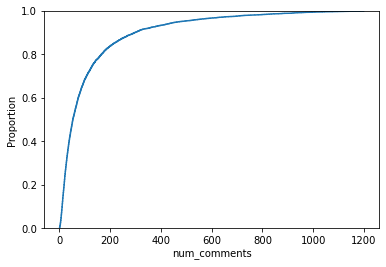

In [27]:
sns.ecdfplot(data=df, x='num_comments');

''

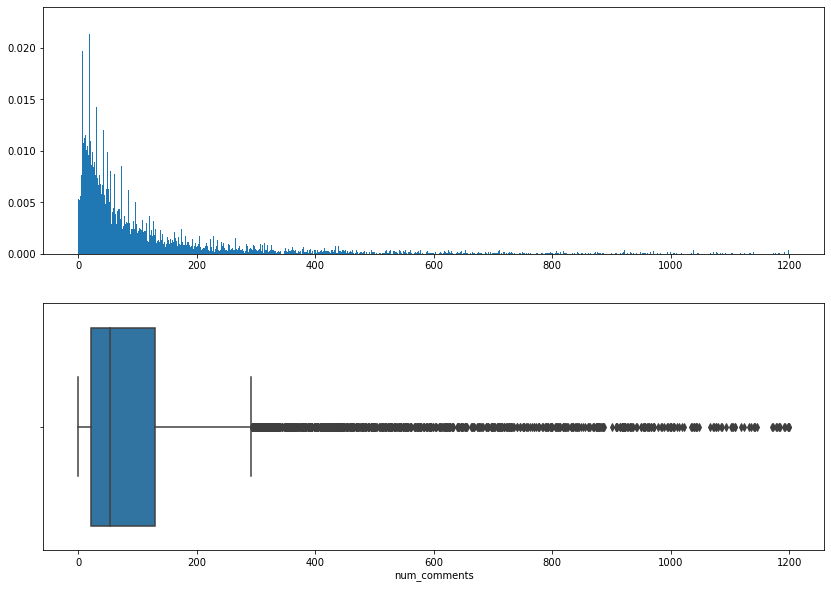

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

ax[0].hist(df.num_comments, 1000, density = True, 
         histtype ='bar')
sns.boxplot(x='num_comments', data=df, ax=ax[1])           
;

**Target** 

Observations 
- The Target of being above or below the median num_comments is heavily skewed. For this reason we decided to limit the dataset to posts that had less than 1200 comments. We removed 200 posts above this limit. 
- After modeling and selecting the best model, we will readdress this decision and see if it ultimately made any difference in our models accuracy. 

## Nominal Variables EDA

**```subreddit```**

In [29]:
df.subreddit.nunique()

2164

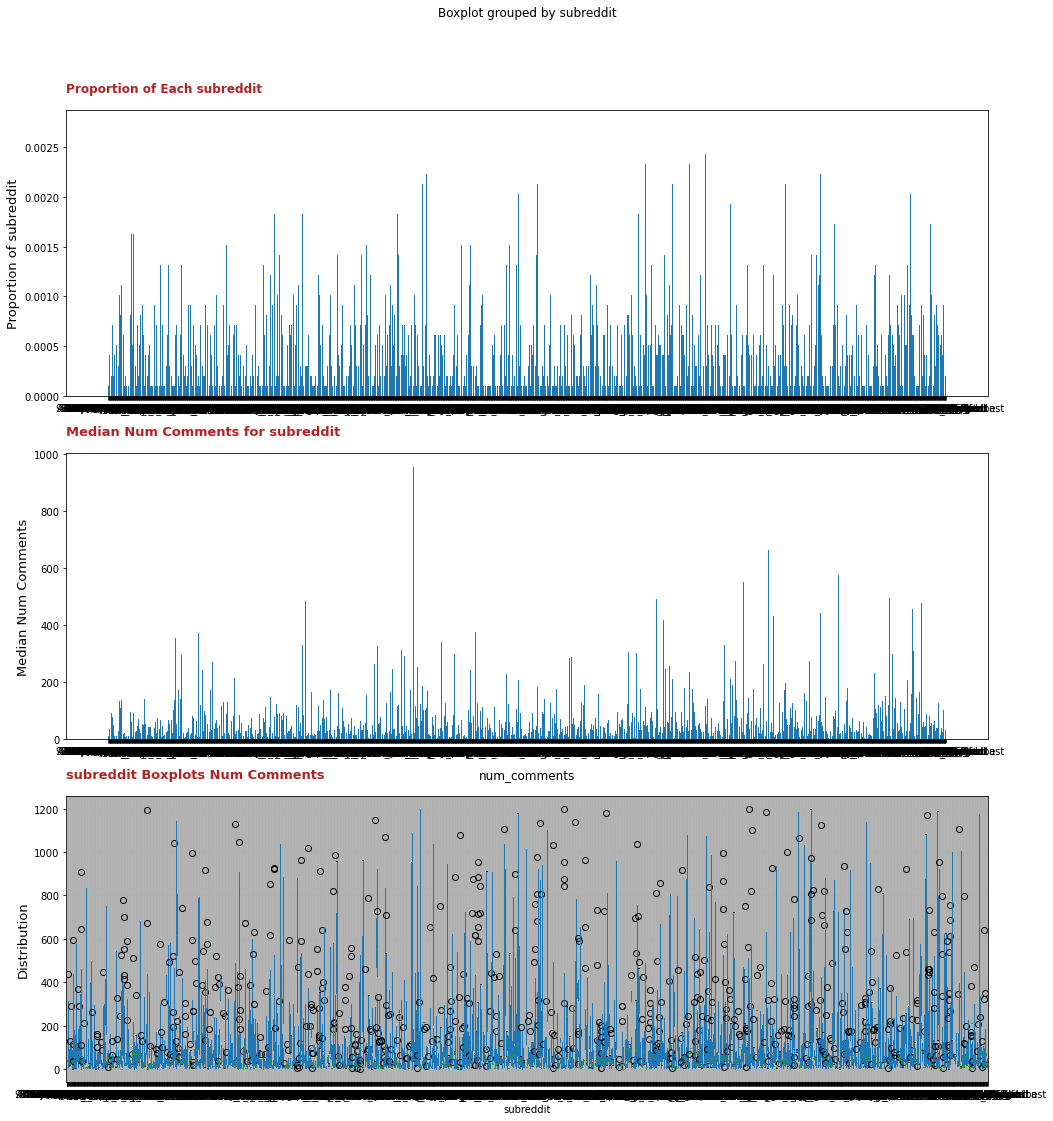

In [31]:
plot_nominal_feature('subreddit')

**```subreddit```**

Observations
- we decided to tdifvectorize this feature, even though each subreddit consists of a single string. Including it increased that accuracy of all three models by at least 2%. 

**```upvote_ratio```**

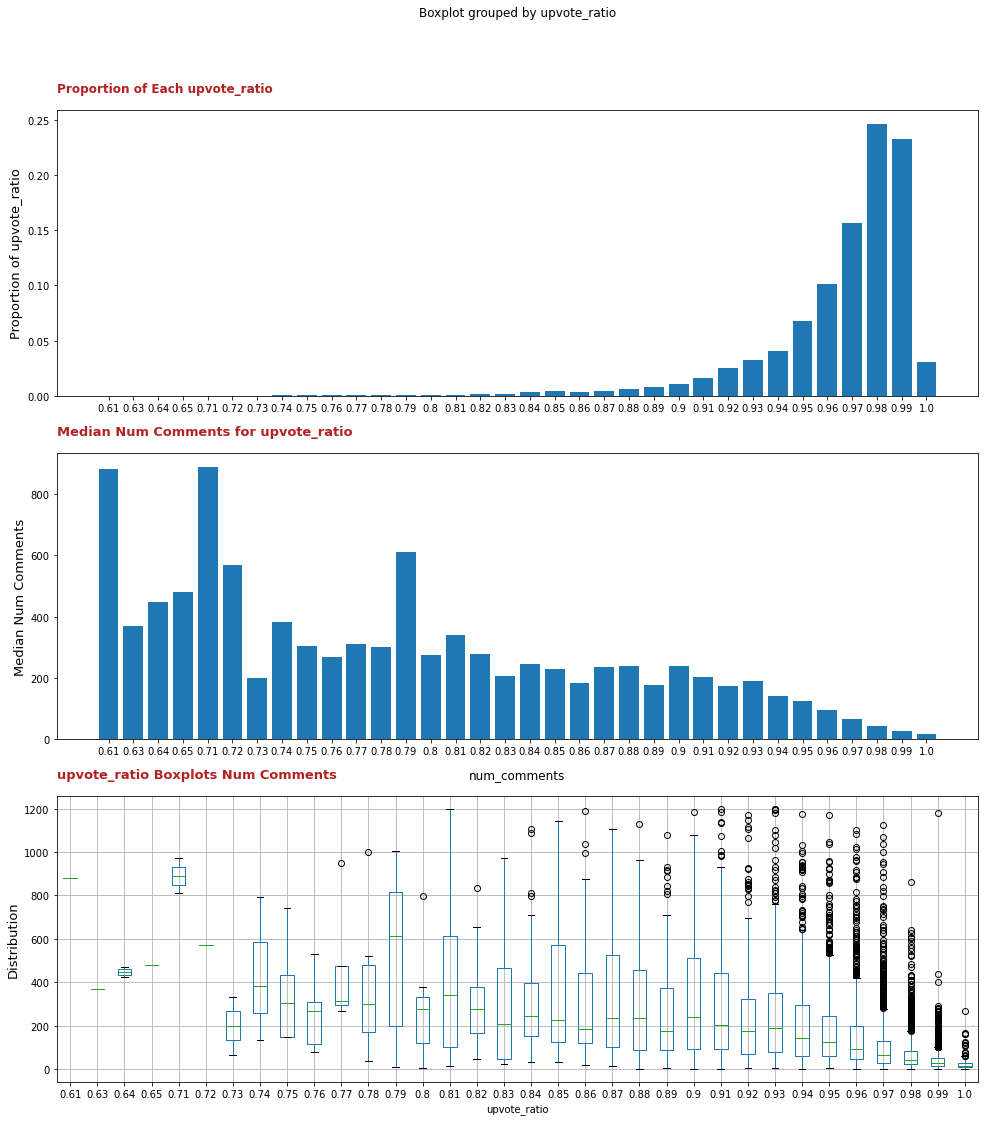

In [32]:
plot_nominal_feature('upvote_ratio')

In [33]:
round(np.corrcoef(df.num_comments, df.upvote_ratio)[0, 1], 3)

-0.477

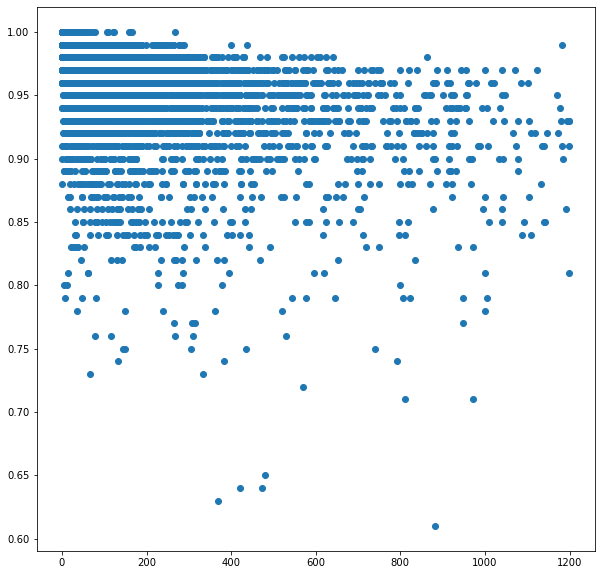

In [34]:
fix, ax = plt.subplots(figsize=(10, 10))

ax.scatter(df.num_comments, df.upvote_ratio);

**```upvote_ratio``` vs. ```num_comments```**
- This feature does not have a correlation with the target. 
- It is interesting that posts with low```num_comments``` have high ```upvote_ratio``` for the most part. This may be because the algorithm that Reddit uses to classify posts as "hot" gives this feature significant weight. 
- For our model that compares the ```num_comments``` for a post relative to the median, this feature will not be useful in our model. This feature is being dropped. 

In [35]:
df.drop(labels=['upvote_ratio'], axis=1, inplace=True)

**```is_original_content```** (1) OHE

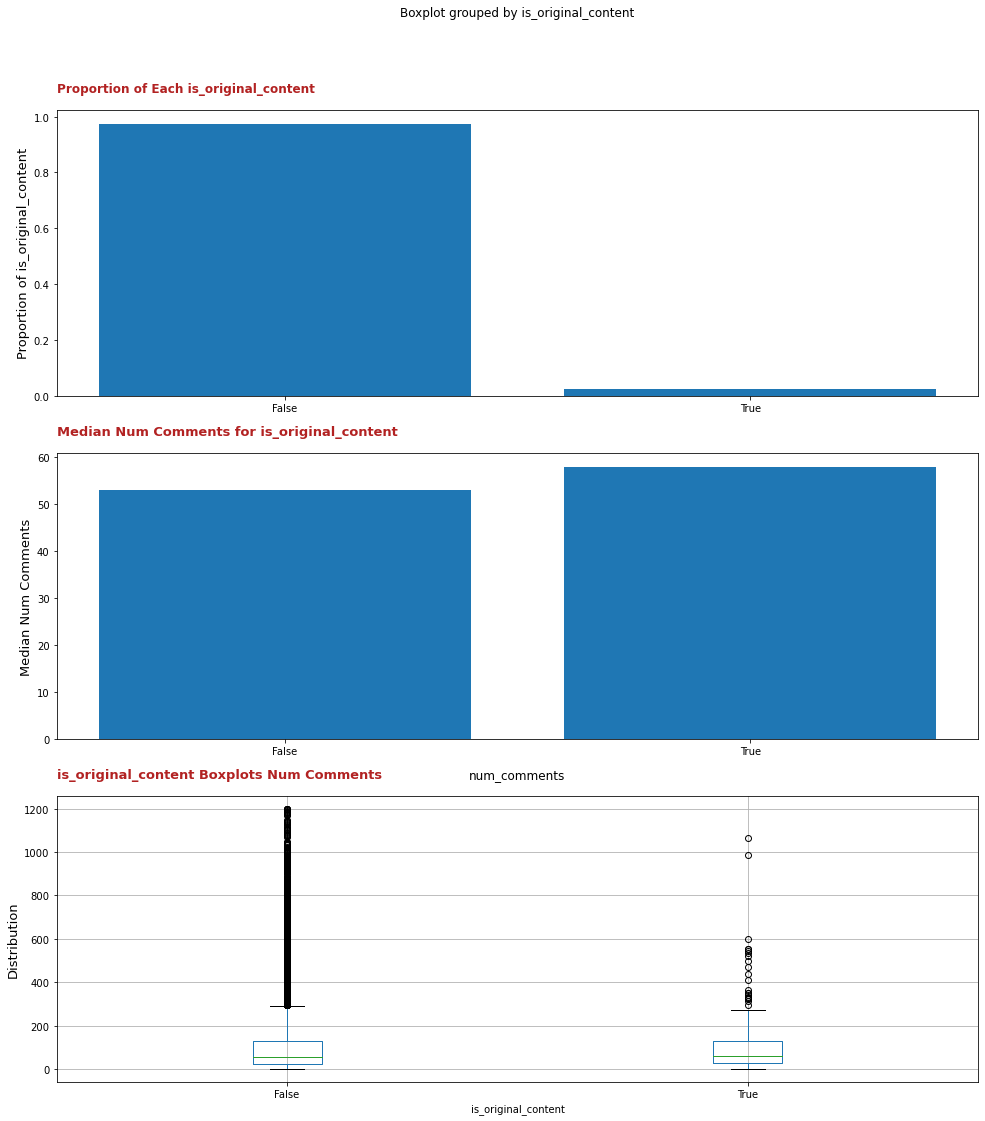

In [36]:
plot_nominal_feature('is_original_content')

**```is_original_content```** 

Observation
- this feature most likely will only be useful in the Random Forest Model as most Reddit posts are not original
- our Logistic Regression model will use Lasso and most likely exclude this feature. 
- the Random Forest model may give this feature a small importance, but ultimately increase its accuracy in predictions. 

**```is_self```** (1) OHE

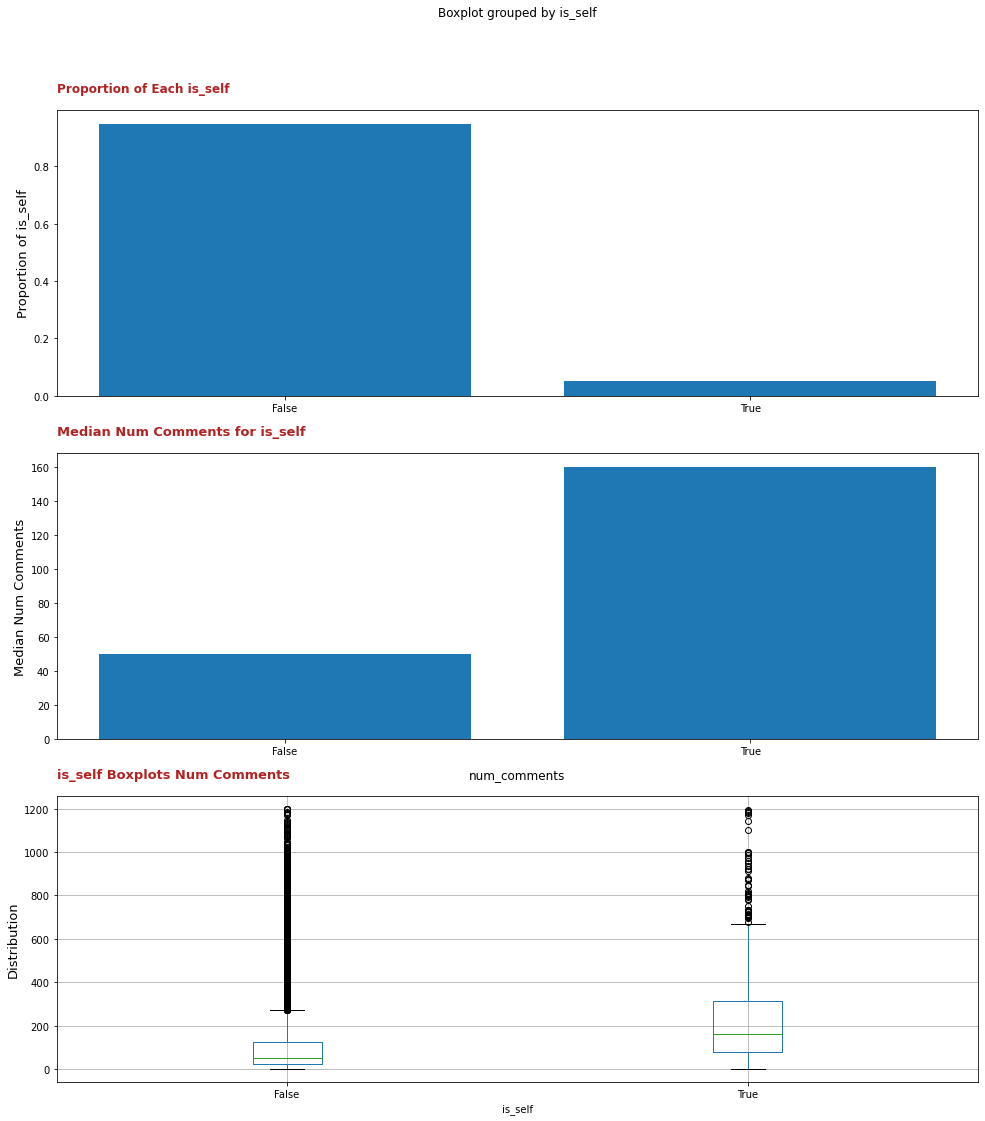

In [37]:
plot_nominal_feature('is_self')

**Is Self**

Observation
- posts with only text (no visual components) area recorded as "is_self"
- more than 90% of the posts in this dataset are not "text only"
- posts that only consist of text have higher user interaction
- this feature will be included in our models

**```is_video```** (1) OHE

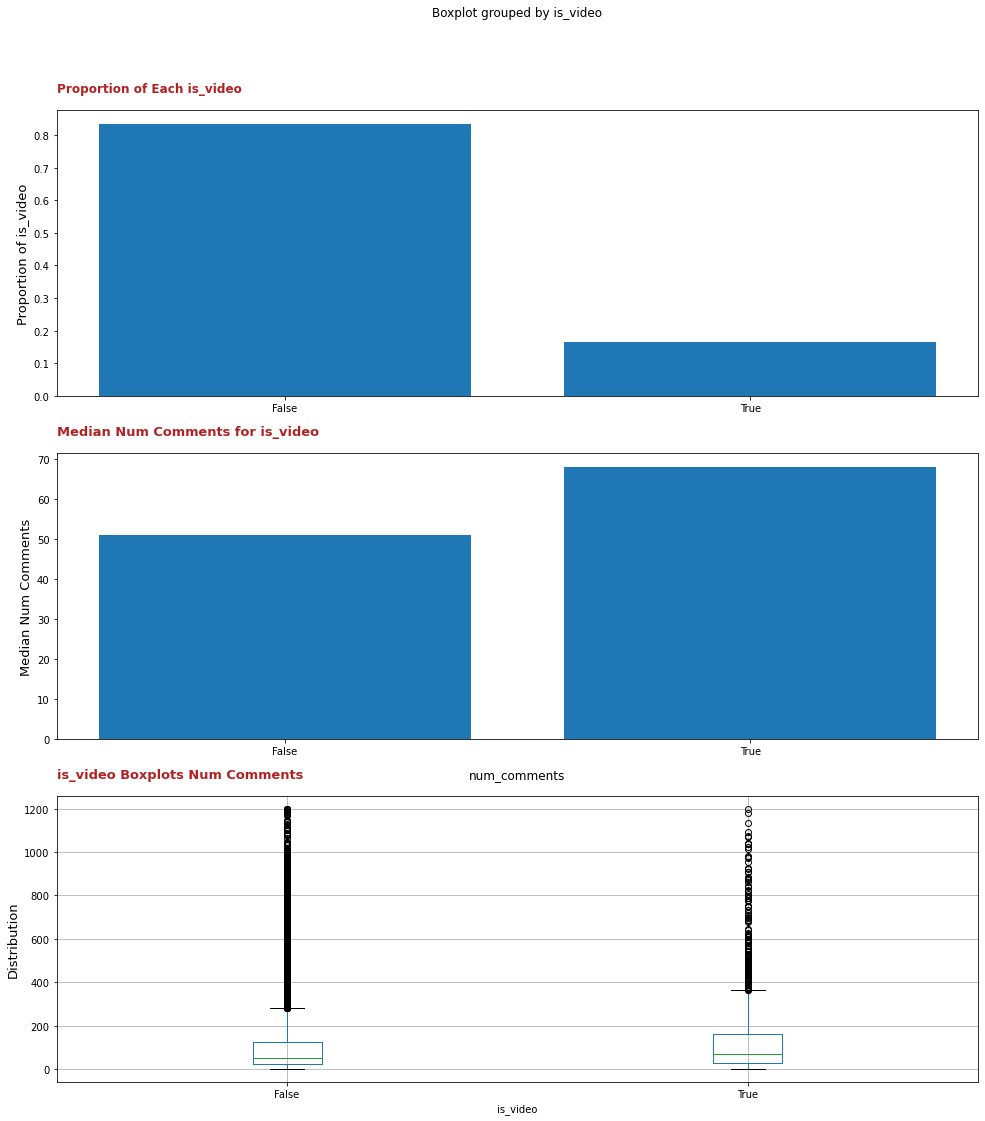

In [38]:
plot_nominal_feature('is_video')

**Is Video**

Observation
- less than 2% of the posts in this dataset contain a video
- those that do have more user interaction 
- this feature will be included in our feature in slightly increase classification accuracy

**```over_18```** (1) OHE

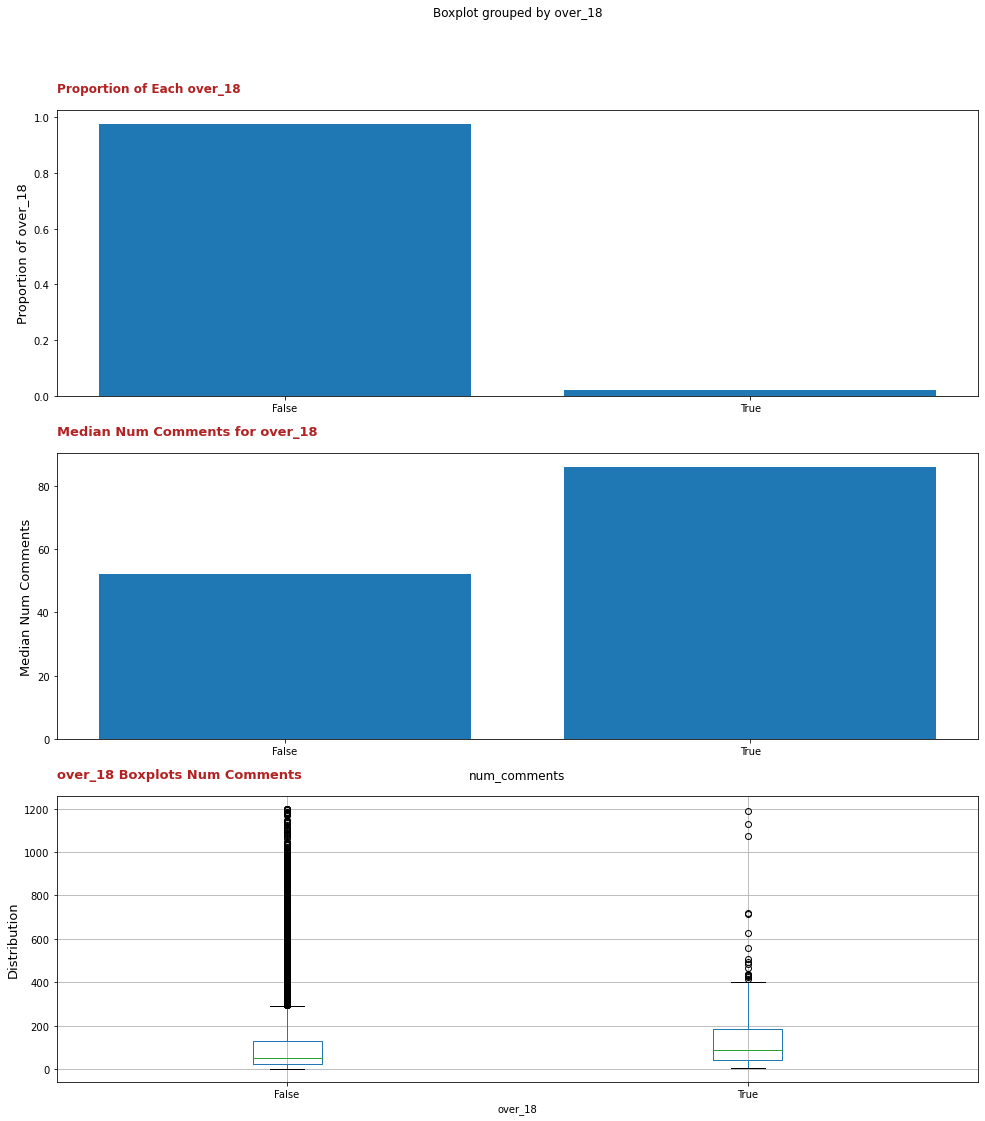

In [39]:
plot_nominal_feature('over_18')

**Over 18**

Observation
- almost all posts are not restricted to "over 18"
- those that are have higher user interaction
- this feature will be included in our model to slightly increase accuracy

**```spoiler```** (1) OHE

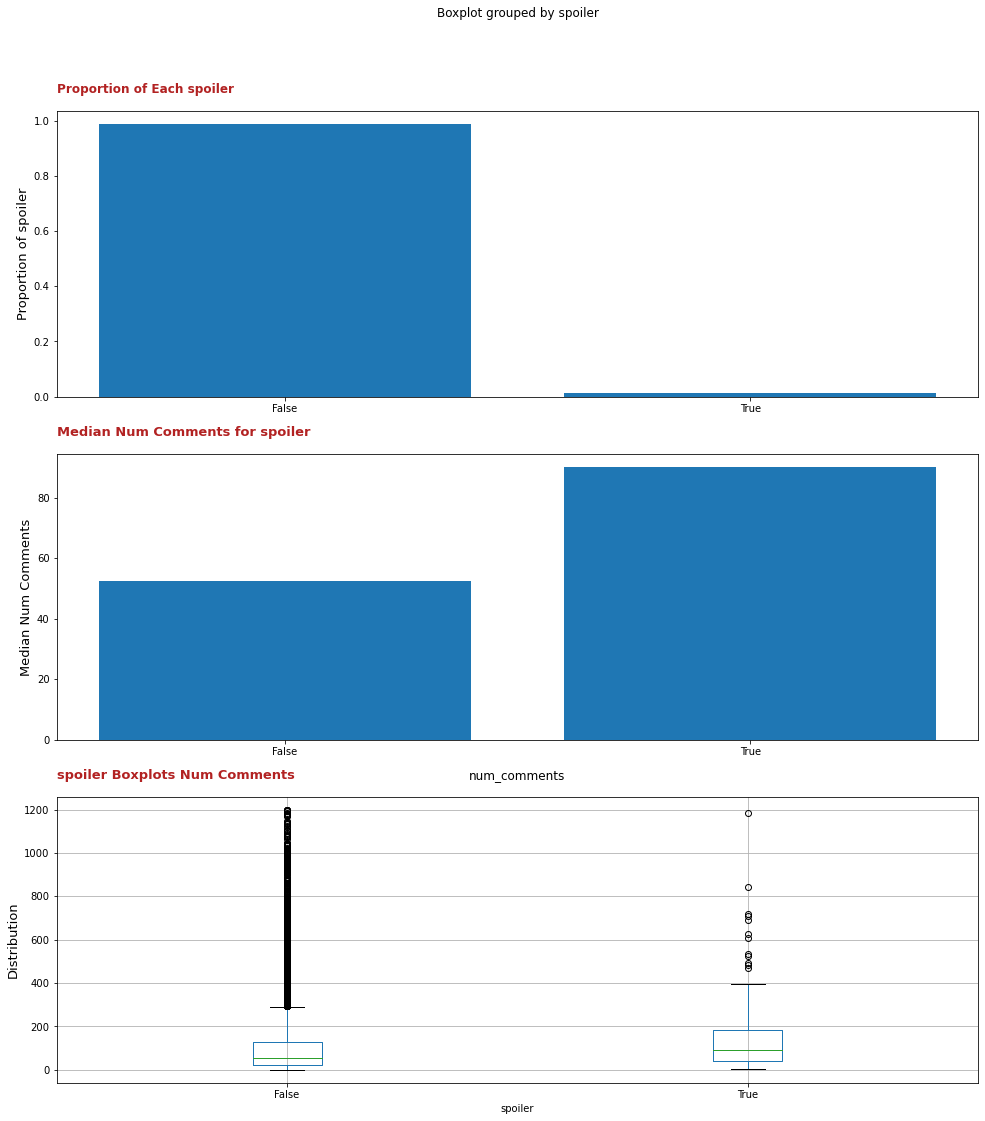

In [40]:
plot_nominal_feature('spoiler')

**Spoiler**

Observations
- almost all posts are not "spoilers', but those that are have more user interaction
- this feature will be included in our models to slightly increase accuracy, especially for the Random Forest model

**Creating Dummies for selected features**

In [41]:
df = pd.get_dummies(data=df, columns=['is_original_content', 
                                      'is_self', 
                                      'is_video', 
                                      'over_18', 
                                      'spoiler'
                                     ]
                    , drop_first=True)

## Continuous Variables EDA

In [42]:
def plot_continuous_feature(feature):

    corr = round(np.corrcoef(df['num_comments'], df[feature])[0, 1], 3)
    
    fig, ax = plt.subplots(2, 1, figsize=(16, 14))

# Distribution of ordinal feature     
    
    ax[0].hist(df[feature], bins=20)
    ax[0].set_xlabel(feature, fontsize=13)
    ax[0].set_ylabel('Freq of ' + feature)
    ax[0].set_title(feature + ' Distribution', 
                    fontweight='bold', 
                    color='firebrick', 
                    pad=18, 
                    loc='left')

# Scatter Plot of ordinal feature     
    
    ax[1].scatter(df[feature], df['num_comments'])
    ax[1].set_xlabel(feature, fontsize=13)        
    ax[1].set_ylabel('Num Comments')
    ax[1].set_title(feature + ' vs. Num Comments Corr: ' + str(corr), 
                fontweight='bold', 
                color='firebrick', 
                pad=18, 
                loc='left') 

**`num_crosspsts`**

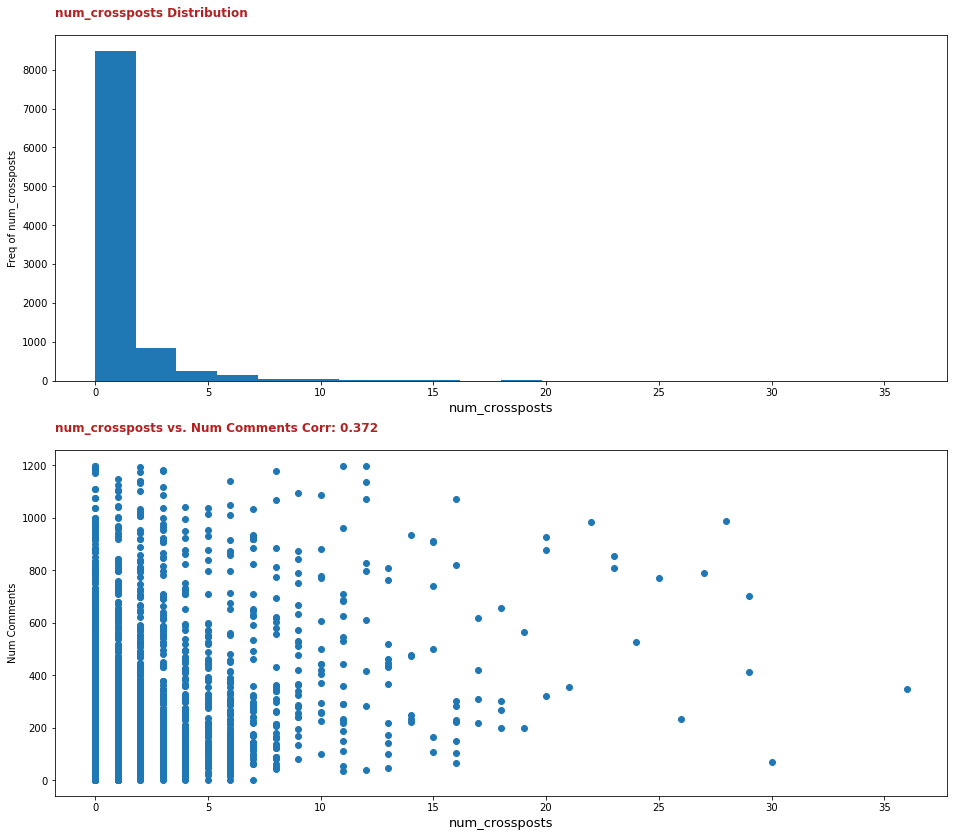

In [43]:
plot_continuous_feature('num_crossposts')

In [44]:
df.num_crossposts.value_counts(normalize=True).head()

0    0.698186
1    0.160535
2    0.057667
3    0.027465
4    0.016418
Name: num_crossposts, dtype: float64

**`num_crosspsts`**

Observations
- 85% of the dataset had fewer than 2 cross posts
- this feature is not significantly correlated with the target
- The Random Forest model gave this feature high importance, most likely at deeper nodes

**`length_time_seconds`**

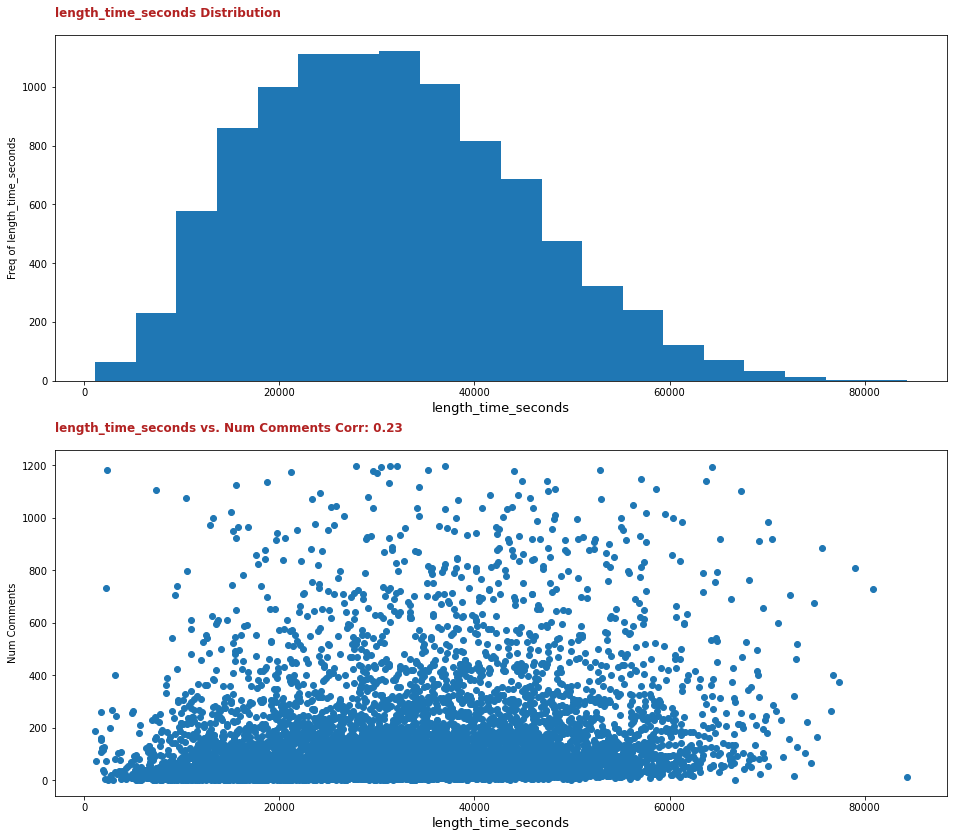

In [45]:
plot_continuous_feature('length_time_seconds')

**`length_time_seconds`**

Observations
- this feature is not significantly correlated to the target
- the Random Forest model gave this feature a high importance

**`score`**

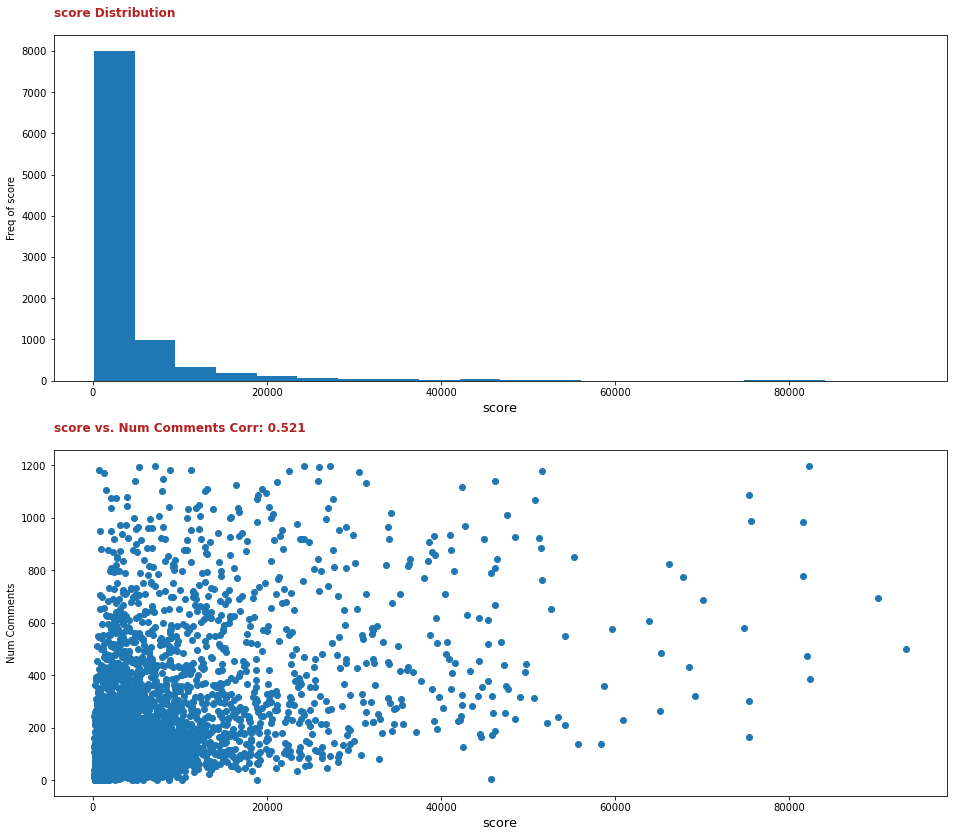

In [46]:
plot_continuous_feature('score')

**`score`**

Observation
- there are 4 posts with scores over 100,000. We will drop these outliers to reduce the skew of the distribution 
- this feature is not significantly correlated with the target
- we included it in our models mainly for Random Forest to use
- this feature ultimately was the most important feature for the Random Forest model

**`subreddit_subscribers`**

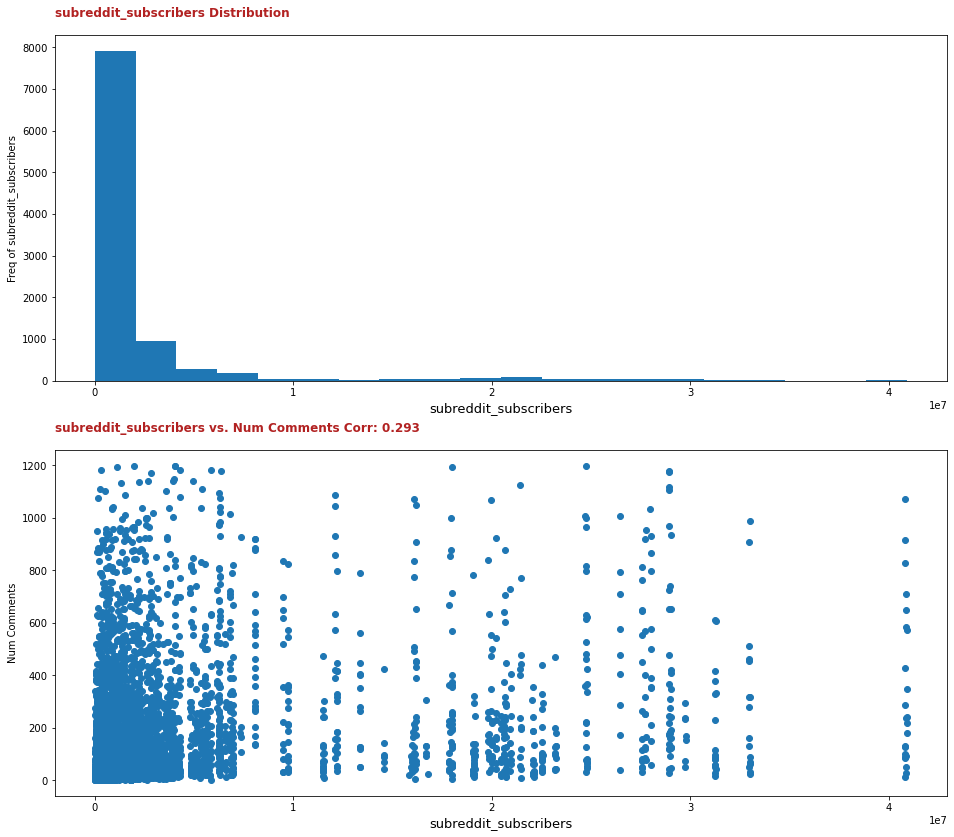

In [47]:
plot_continuous_feature('subreddit_subscribers')

**`subreddit_subscribers`**

Observations
- this feature has no direct correlation with interaction with Reddit posts
- we included it for our Random Forrest to take advantage of it when necessary
- ultimately it was not as important in predictions as other features

---
---

# Natural Language Processing

## NLP Text Cleaning

**Normalizing `title`**

In [49]:
df.title = [string.lower() for string in df.title]

**Quotations Removal**

In [50]:
df.title = [char.replace("'", '')
                .replace('"', '')
                .replace('“', '')
                .replace('”', '')
                .replace('‘', ' ')
                .replace("’", '')
            for char in df.title]

**Emojis Removal**

In [51]:
df.title = [emoji.demojize(string, delimiters=("", "")) 
            for string in df.title]

In [52]:
df.title = [char.replace('🫥', ' ')
                .replace('🥲', ' ')
                .replace('🫘', ' ') 
            for char in df.title]

**Special Characters Removal**

In [53]:
df.title = [char.replace(':', '')
            .replace(';', '')
            .replace('...', '')
            .replace('…', '')
            .replace('.', ' ')
            .replace(',', ' ')
            .replace('(', '')
            .replace(')', '')
            .replace('[', '')
            .replace(']', '')
            .replace('{', '')
            .replace('}', '')
            .replace('-', ' ')
            .replace('—', '')
            .replace('_', ' ')
            .replace('_', ' ')
            .replace('–', ' ')
            .replace('/', ' ')
            .replace('|', ' ')
            .replace('&', ' ')
            .replace('%', ' ')
            .replace('@', ' ')
            .replace('$', ' ')
            .replace('+', '')
            .replace('#', ' ')
            .replace('*', ' ')
            .replace('^', ' ')
            .replace('<', ' ')
            .replace('>', ' ')
            .replace('=', ' ')
            .replace('~', ' ')
            .replace('  ', ' ')
            .replace('  ', ' ')
            .strip()
            for char in df.title]

**Accents Removal**

In [54]:
df.title = [unidecode.unidecode(title) for title in df.title]

**Repeated Characters Reduction**

In [55]:
df.title = [' '.join([re.sub(r'(.)\1+', r'\1\1', word) for word in title.split(' ')]) for title in df.title]

**Dropping Empty `title` after nlp cleanup**

In [56]:
df.drop(index=df[df.title == ''].index, inplace=True)

**Dropping rows with title length less than 6**

In [57]:
df.reset_index(drop=True, inplace=True)
df.drop(index=[i for i, title in enumerate(df.title) if len(title) < 6])
df.reset_index(drop=True, inplace=True)

## Lemmatizing 

In [58]:
nlp = spacy.load("en_core_web_sm")

In [59]:
nlp = spacy.load('en_core_web_sm')

df['doc'] = [nlp(text) for text in df.title]

In [60]:
df['lemmatized'] = [' '.join([str(token.lemma_) for token in doc]) for doc in df.doc]

Dropping duplicates in title after lemmatizing title

In [61]:
df.drop_duplicates(subset=['lemmatized'], keep='last', inplace=True)
df.reset_index(drop=True, inplace=True)

In [62]:
# for token in df.doc[:5]:
#     print(token)

/Users/andrewdeemer/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


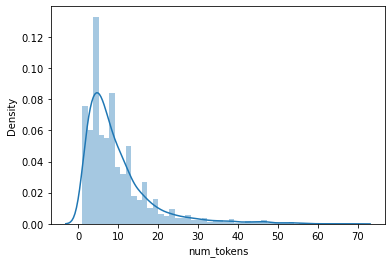

In [63]:
df['num_tokens'] = [len(token) for token in df.doc]

sns.distplot(df.num_tokens);

**Lemmatizing Title**

Observations
- most titles have less than 15 reduced words
- we included this feature in our models, though it did not significantly affect their accuracy. 

## Stemming with NLTK

In [64]:
stemmer = PorterStemmer()
df['stemmed_title'] = [' '.join([stemmer.stem(word) for word in sentence.split(' ')]) 
                       for sentence in df.title]

**Dropping Duplicates after tdifvectorize**

In [65]:
df.stemmed_title.duplicated().value_counts()

False    9753
True        1
Name: stemmed_title, dtype: int64

In [66]:
df.drop_duplicates(subset=['stemmed_title'], keep='last', inplace=True)
df.reset_index(drop=True, inplace=True)

**Creating `title_length`**
- this manufactured feature will be the number of words in a title after stemming

In [67]:
df['stem_count'] = [0 for count in df.stemmed_title]
for i, words in enumerate(df.stemmed_title):
    df.stem_count.iloc[i] = len(words.split(' '))

/Users/andrewdeemer/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


---
---

# MODELS

# KNN

### Train Test Split
- We create our X features and y target before creating a train test split. 
- subsequently we test and tune the tfidfvectorizer on stemmed `title` and `subreddit` vs. lemmatized text. 

In [69]:
# Features to add/subtract
y = df.target
X = df[['lemmatized', 'subreddit',
        # dummies
        'is_original_content_True', 'is_self_True','is_video_True', 
        'over_18_True', 'spoiler_True',
        # continuous         
        'num_crossposts', 'length_time_seconds', 'score', 
        'subreddit_subscribers', 'num_tokens'
       ]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=73)

### TfidfVectorizer 
- we test the different outcomes in our model between including stemmed text vs lemmatized text for `title` and `subreddit`
- we also tune parameters to see if our model improves by changing max_features, max_df, and norm

In [70]:
# Vectorizing Title
tvec = TfidfVectorizer(stop_words = 'english',
                       strip_accents = 'ascii',
                       max_features = 50,
                       max_df = .60,
                       norm = 'l2' 
                      )
tvec.fit(X_train.lemmatized)

# Creating df from vectorized title train/test 
train_tvec = pd.DataFrame(tvec.transform(X_train.lemmatized).todense(),
                          columns = tvec.get_feature_names())

test_tvec = pd.DataFrame(tvec.transform(X_test.lemmatized).todense(),
                          columns = tvec.get_feature_names())

#  Merging vectorized title to train/test
X_train = X_train.reset_index(drop=True).join(train_tvec) \
                                        .drop('lemmatized', axis=1)

X_test = X_test.reset_index(drop=True).join(test_tvec)\
                                        .drop('lemmatized', axis=1)

# Vectorizing subreddit
tvec = TfidfVectorizer(stop_words = 'english',
                       strip_accents = 'ascii',
                       max_features = 50,
                       max_df = .60,
                       norm = 'l2' # normalizing using ridge
                      )
tvec.fit(X_train.subreddit)

# Creating df from vectorized title train/test 
train_tvec_subreddit = pd.DataFrame(tvec.transform(X_train.subreddit)
                                    .todense(),
                          columns = tvec.get_feature_names())

test_tvec_subreddit = pd.DataFrame(tvec.transform(X_test.subreddit)
                                   .todense(),
                          columns = tvec.get_feature_names())

#  Merging vectorized title to train/test
X_train = X_train.reset_index(drop=True).join(train_tvec_subreddit) \
                                        .drop('subreddit', axis=1)

X_test = X_test.reset_index(drop=True).join(test_tvec_subreddit)\
                                        .drop('subreddit', axis=1)

### KNN Pipeline and Gridsearch

In [71]:
params = {'knn__n_neighbors': list(range(10, 50, 5)),
          'knn__weights': ['uniform', 'distance'],
          'knn__p': [1, 2, 3],                    
          'ss__with_mean': [True, False], 
          'ss__with_std': [True, False]
         }

pipe = Pipeline([('ss', StandardScaler()),
                 ('knn', KNeighborsClassifier(n_jobs=-1))
                ])

knn_gridsearch = GridSearchCV(pipe, 
                              params, 
                              cv=5, 
#                               verbose=1, 
                              n_jobs=-1)

knn_gridsearch.fit(X_train, y_train)

print(knn_gridsearch.best_params_)
print('\nBest Score:', round(knn_gridsearch.best_score_, 4))
print('Test Score:', round(knn_gridsearch.score(X_test, y_test), 4))

/Users/andrewdeemer/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'knn__n_neighbors': 20, 'knn__p': 1, 'knn__weights': 'distance', 'ss__with_mean': True, 'ss__with_std': False}

Best Score: 0.695
Test Score: 0.6954


### KNN Cross Val Score w/ Best Parameters
- after gridsearch returned the best parameters for our transformer and estimator, we confirm the results by recreating the steps and running cross val score to see our mean scores and confidence intervals

In [72]:
ss = StandardScaler(with_mean=True, with_std=False)
ss.fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=20, p=1, weights='distance')
knn.fit(X_train_ss, y_train)

train_scores = cross_val_score(knn, X_train_ss, y_train)
test_scores = cross_val_score(knn, X_test_ss, y_test)
baseline = round(df.target.value_counts(normalize=True)[0],3)

print('Baseline:', baseline, '\n')

print('Train scores:', train_scores)
print('Mean:', round(train_scores.mean(), 3))
print('Stdev:', round(2 * train_scores.std(), 3), '\n')

print('Test scores:', test_scores)
print('Mean:', round(test_scores.mean(), 3))
print('Stdev:', round(2 * test_scores.std(), 3), '\n')

Baseline: 0.514 

Train scores: [0.71086808 0.69172932 0.68284347 0.6910458  0.69835841]
Mean: 0.695
Stdev: 0.019 

Test scores: [0.66598361 0.66393443 0.65778689 0.66803279 0.65297741]
Mean: 0.662
Stdev: 0.011 



### KNN Metrics

              precision    recall  f1-score   support

     not_hot       0.70      0.75      0.72      1286
         hot       0.69      0.64      0.66      1153

    accuracy                           0.70      2439
   macro avg       0.70      0.69      0.69      2439
weighted avg       0.70      0.70      0.69      2439



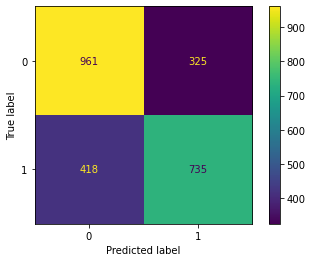

In [73]:
conmat = np.array(confusion_matrix(y_test, 
                                   knn.predict(X_test_ss), 
                                   labels=[0, 1]))

print(classification_report(y_test,
                            knn.predict(X_test_ss), 
                            target_names=['not_hot', 'hot']))

matrix_display = ConfusionMatrixDisplay(confusion_matrix=conmat, 
                                        display_labels=knn.classes_)
matrix_display.plot();

### KNN Analysis
- this model is 66% accurate in predicting the target for posts. 
- fewer neighbors resulted in the highest scores
- this model's attribute of weight for neighbors including distance increased accuracy
- as both Logistic Regression and Random Forest models were more accurate in target predictions, we did not proceed further with tuning this model to increase accuracy. 

# Logistic Regression Pipeline & Gridsearch

### Train Test Split

In [74]:
# Features to add/subtract
y = df.target
X = df[['lemmatized', 'subreddit',
        # dummies
        'is_original_content_True', 'is_self_True','is_video_True', 
        'over_18_True', 'spoiler_True',
        # continuous         
        'num_crossposts', 'length_time_seconds', 'score', 
        'subreddit_subscribers', 'num_tokens'
       ]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=73)

### TfidVectorizer
- lemmatized text for title increased the scores of this model by 2%
- `subreddit` was not stemmed or lemmatized as this feature consisted of a single string for each subreddit

In [75]:
# Vectorizing Title
tvec = TfidfVectorizer(stop_words = 'english',
                       strip_accents = 'ascii',
                       max_features = 50,
                       max_df = .60,
                       norm = 'l2' 
                      )
tvec.fit(X_train.lemmatized)

# Creating df from vectorized title train/test 
train_tvec = pd.DataFrame(tvec.transform(X_train.lemmatized).todense(),
                          columns = tvec.get_feature_names())

test_tvec = pd.DataFrame(tvec.transform(X_test.lemmatized).todense(),
                          columns = tvec.get_feature_names())

#  Merging vectorized title to train/test
X_train = X_train.reset_index(drop=True).join(train_tvec) \
                                        .drop('lemmatized', axis=1)

X_test = X_test.reset_index(drop=True).join(test_tvec)\
                                        .drop('lemmatized', axis=1)

# Vectorizing subreddit
tvec = TfidfVectorizer(stop_words = 'english',
                       strip_accents = 'ascii',
                       max_features = 50,
                       max_df = .60,
                       norm = 'l2' 
                      )
tvec.fit(X_train.subreddit)

# Creating df from vectorized title train/test 
train_tvec_subreddit = pd.DataFrame(tvec.transform(X_train.subreddit)
                                    .todense(),
                          columns = tvec.get_feature_names())

test_tvec_subreddit = pd.DataFrame(tvec.transform(X_test.subreddit)
                                   .todense(),
                          columns = tvec.get_feature_names())

#  Merging vectorized title to train/test
X_train = X_train.reset_index(drop=True).join(train_tvec_subreddit) \
                                        .drop('subreddit', axis=1)

X_test = X_test.reset_index(drop=True).join(test_tvec_subreddit)\
                                        .drop('subreddit', axis=1)

### Logistic Regression Pipeline and GridSearch

In [77]:
logreg_params = {'logreg__penalty': ['l1', 'l2'], 
                 'logreg__solver': ['liblinear', 'saga'],
                 'ss__with_mean': [True, False],
                 'ss__with_std': [True, False]
                }

logreg_pipe = Pipeline([('ss', StandardScaler()),
                        ('logreg', LogisticRegression(random_state=73, 
                                                      max_iter=50000))
                       ])

logreg_gridsearch = GridSearchCV(logreg_pipe, 
                                 logreg_params, 
                                 cv=5, 
#                                  verbose=1, 
                                 n_jobs=-1)

logreg_gridsearch.fit(X_train, y_train)

baseline = round(df.target.value_counts(normalize=True)[0],3)

print(logreg_gridsearch.best_estimator_)
print(logreg_gridsearch.best_params_)

print('Baseline:', baseline)
print('\nBest Score:', round(logreg_gridsearch.best_score_, 4))
print('Test Score:', round(logreg_gridsearch.score(X_test, y_test), 4))

Pipeline(steps=[('ss', StandardScaler(with_mean=False, with_std=False)),
                ('logreg',
                 LogisticRegression(max_iter=50000, penalty='l1',
                                    random_state=73, solver='liblinear'))])
{'logreg__penalty': 'l1', 'logreg__solver': 'liblinear', 'ss__with_mean': False, 'ss__with_std': False}
Baseline: 0.514

Best Score: 0.7397
Test Score: 0.7405


### Logistic Regression Tuned Model Cross Val Score

In [78]:
# Standard Scaline 
ss = StandardScaler(with_mean=False, with_std=False)
ss.fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

# Fitting Model
logreg = LogisticRegression(max_iter=50000, 
                            penalty='l1', 
                            random_state=73, 
                            solver='liblinear')
logreg.fit(X_train_ss, y_train)

train_scores = cross_val_score(logreg, X_train_ss, y_train)
test_scores = cross_val_score(logreg, X_test_ss, y_test)
baseline = round(df.target.value_counts(normalize=True)[0],3)

print('Baseline:', baseline, '\n')

print('Train scores:', train_scores)
print('Mean:', round(train_scores.mean(), 3))
print('Stdev:', round(2 * train_scores.std(), 3), '\n')

print('Test scores:', test_scores)
print('Mean:', round(test_scores.mean(), 3))
print('Stdev:', round(2 * test_scores.std(), 3), '\n')

Baseline: 0.514 

Train scores: [0.73820916 0.73615858 0.74094327 0.74504443 0.7380301 ]
Mean: 0.74
Stdev: 0.006 

Test scores: [0.73155738 0.72745902 0.74180328 0.7397541  0.71457906]
Mean: 0.731
Stdev: 0.02 



## Logistic Regression Metrics

              precision    recall  f1-score   support

     not_hot       0.73      0.82      0.77      1286
         hot       0.76      0.65      0.70      1153

    accuracy                           0.74      2439
   macro avg       0.74      0.74      0.74      2439
weighted avg       0.74      0.74      0.74      2439



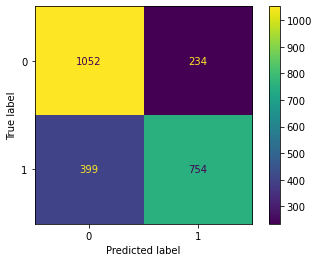

In [79]:
conmat = np.array(confusion_matrix(y_test, 
                                   logreg.predict(X_test_ss), 
                                   labels=[0, 1]))

print(classification_report(y_test,
                            logreg.predict(X_test_ss), 
                            target_names=['not_hot', 'hot']))

matrix_display = ConfusionMatrixDisplay(confusion_matrix=conmat, 
                                        display_labels=logreg.classes_)
matrix_display.plot();

### Logistic Regression Analysis

- this model was 73% accurately in predicting the target class 
- this model was more accurate in predicting "hot" posts than "not hot" posts
- below we examine the features in this model that key indicators of our target. 
- lasso removed 31 of 110 features from the model

### Feature Coefficients

In [81]:
logreg_coefs = pd.DataFrame(list(zip(X_train.columns, np.expm1(logreg.coef_[0]))), 
                           columns=['features', 'coef'])

logreg_coefs['abs'] = abs(logreg_coefs['coef'])

In [82]:
logreg_coefs.sort_values('abs', ascending=False)

,features,coef,abs
89,politicalcompassmemes,15.160474,15.160474
96,squaredcircle,9.814463,9.814463
1,is_self_True,4.038180,4.038180
90,politicalhumor,3.462869,3.462869
78,idiotsincars,3.143060,3.143060
...,...,...,...
80,latestagecapitalism,0.000000,0.000000
81,lotrmemes,0.000000,0.000000
82,mademesmile,0.000000,0.000000
35,man,0.000000,0.000000


**Features removed from Logistic Regression Model by Lasso**

In [83]:
logreg_coefs.sort_values('abs', ascending=False).tail(31)

,features,coef,abs
27,know,0.0,0.0
99,suspiciouslyspecific,0.0,0.0
14,come,0.0,0.0
97,suddenlygay,0.0,0.0
102,unexpected,0.0,0.0
103,wallstreetbets,0.0,0.0
93,programmerhumor,0.0,0.0
92,prequelmemes,0.0,0.0
108,witchesvspatriarchy,0.0,0.0
10,2022,0.0,0.0


**```is_original_content```** (1) OHE

### Top Features

**Top Subreddit Class Indicators**
- Top 5 subreddit class indicators: 'wholesomememes', 'PoliticalHumor', 'IdiotsInCars', 'SquaredCircle', 'PoliticalCompassMemes'

''

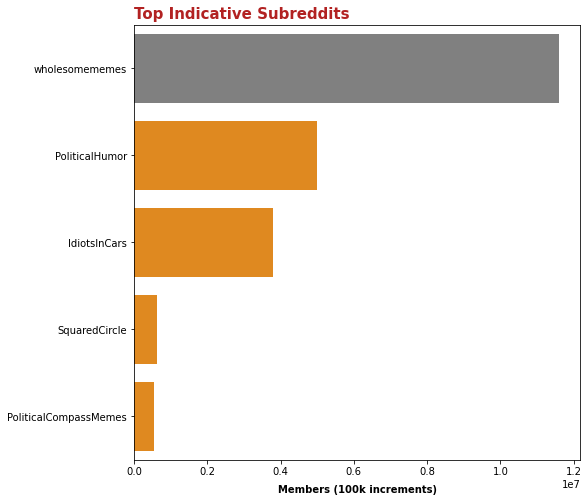

In [84]:
top_subreddits = pd.DataFrame({'subreddit':['wholesomememes', 
                                            'PoliticalHumor', 
                                            'IdiotsInCars', 
                                            'SquaredCircle',
                                            'PoliticalCompassMemes'],
                               'members': [11600000, 5000000, 3800000, 
                                           635000, 546000], 
            'num_posts': [len(df[df.subreddit == 'wholesomememes']),
                          len(df[df.subreddit == 'PoliticalHumor']),
                          len(df[df.subreddit == 'IdiotsInCars']), 
                          len(df[df.subreddit == 'SquaredCircle']), 
                          len(df[df.subreddit == 'PoliticalCompassMemes'])]})

fig, ax = plt.subplots(figsize=(8,8))

clrs = ['grey' if x == 'wholesomememes' else 'darkorange' for x in top_subreddits.subreddit]

sns.barplot(x='members', y='subreddit', data=top_subreddits, ax=ax, 
            palette=clrs, )

ax.set_title('Top Indicative Subreddits', fontsize=15, 
                fontweight='bold', color='firebrick', loc='left')

ax.set_ylabel('')
ax.set_xlabel('Members (100k increments)', weight='bold', labelpad=8)
ax.text
;

In [85]:
top_subreddits

,subreddit,members,num_posts
0,wholesomememes,11600000,19
1,PoliticalHumor,5000000,21
2,IdiotsInCars,3800000,18
3,SquaredCircle,635000,14
4,PoliticalCompassMemes,546000,17


In [86]:
logreg_coefs[(logreg_coefs.features == 'wholesomememes') | \
             (logreg_coefs.features == 'politicalhumor') | \
             (logreg_coefs.features == 'idiotsincars') | \
             (logreg_coefs.features == 'squaredcircle') | \
             (logreg_coefs.features == 'politicalcompassmemes')] \
            [['features', 'coef']]

,features,coef
78,idiotsincars,3.143060
89,politicalcompassmemes,15.160474
90,politicalhumor,3.462869
96,squaredcircle,9.814463
107,wholesomememes,-0.837146


**Subreddit Indicator**
- meme types have different interaction levels. Basic funny memes do not get much interaction
- wholesomememes subreddit have the most members, but contrary to assumption, interaction level is low. 
- Political based posts elicit more responses.
- SquaredCircle subreddit is a WWE group. Members are highly active in this area. 

**Most Predictive Words**
- "world", "game", "feel", "people", "cat"

''

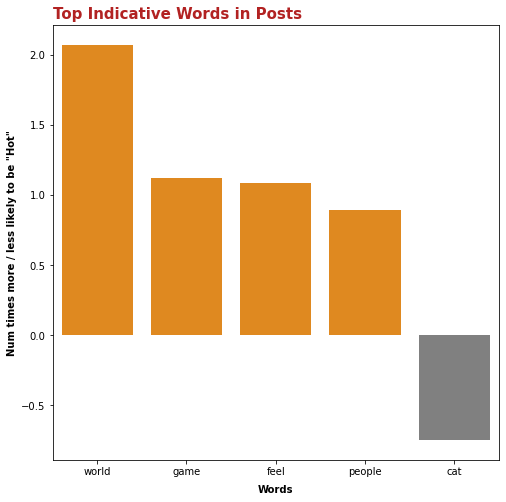

In [87]:
top_words = pd.DataFrame({'words':['world', 
                                   'game', 
                                   'feel', 
                                   'people',
                                   'cat'],
                          'coef': [2.073562,
                                   1.120201,
                                   1.089284,
                                   0.895119,
                                   -0.747250
                                  ]})

fig, ax = plt.subplots(figsize=(8,8))

clrs = ['grey' if x == 'cat' else 'darkorange' for x in top_words.words]

sns.barplot(x='words', y='coef', data=top_words, ax=ax, 
            palette=clrs, )

ax.set_title('Top Indicative Words in Posts', fontsize=15, 
                fontweight='bold', color='firebrick', loc='left')

ax.set_ylabel('Num times more / less likely to be "Hot"', weight='bold')
ax.set_xlabel('Words', weight='bold', labelpad=8)
;

In [88]:
top_words

,words,coef
0,world,2.073562
1,game,1.120201
2,feel,1.089284
3,people,0.895119
4,cat,-0.747250


**Top Indicative Words**
- posts about the world, most likely current events, elicit lots of responses
- there are lots of active sports fans responding to posts
- "feel" posts are most likely opinionated and elicit lots of responses
- posts about cats are not usually that "Hot"

**Is Self Feature:** Reddit post title is text only or includes visual components

In [89]:
df.is_self_True.value_counts(normalize=True)

0    0.949246
1    0.050754
Name: is_self_True, dtype: float64

In [90]:
df.groupby('is_self_True')['num_comments'].mean()

is_self_True
0    110.411968
1    247.638384
Name: num_comments, dtype: float64

In [91]:
is_self_df = pd.DataFrame({'Is Self': ['More than Text', 'Text Only'], 
                           'Median Num Comments': [df.groupby('is_self_True')\
                                                   ['num_comments'].mean()[0],
                                                   df.groupby('is_self_True')\
                                                   ['num_comments'].mean()[1]]})

is_self_df

,Is Self,Median Num Comments
0,More than Text,110.411968
1,Text Only,247.638384


In [92]:
df[df.is_self_True == 1].sort_values \
('num_comments', ascending=False)[['num_comments', 'title']][:5]

,num_comments,title
5684,1193,anyone elses street doing sod all for the jubi...
6599,1192,tifu by eating ramen before inviting a guy over
7169,1184,i wish tower damage was kept as it is right now
3873,1182,post game thread the boston celtics defeat the...
2577,1171,if a girl hits you are you going to hit her back?


''

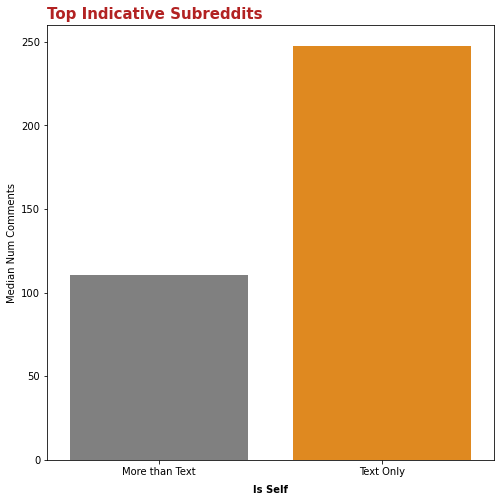

In [93]:
fig, ax = plt.subplots(figsize=(8,8))

clrs = ['grey' if x == '3. wholesomememes' else 'darkorange' for x in top_subreddits.subreddit]

sns.barplot(x='Is Self', y='Median Num Comments', data=is_self_df, ax=ax, 
           palette=['grey', 'darkorange'])

ax.set_title('Top Indicative Subreddits', fontsize=15, 
                fontweight='bold', color='firebrick', loc='left')

# ax.set_ylabel('')
ax.set_xlabel('Is Self', weight='bold', labelpad=8)
;

**Is Self**

Observations
- posts that only contain text make up 5% of the dataset
- posts that only include text are 4 times more likely to be "hot"
- these posts are often opinions or controversial statements and elicit high levels of interaction from Reddit users

# Random Forrest

### Train Test Split

In [94]:
# Features to add/subtract
y = df.target
X = df[['lemmatized', 'subreddit',
        # dummies
        'is_original_content_True', 'is_self_True','is_video_True', 
        'over_18_True', 'spoiler_True',
        # continuous         
        'num_crossposts', 'length_time_seconds', 'score', 
        'subreddit_subscribers', 'num_tokens'
       ]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=73)

### TfidfVectorizer

In [95]:
tvec = TfidfVectorizer(stop_words = 'english',
                       strip_accents = 'ascii',
                       max_features = 50,
                       max_df = .60,
                       norm = 'l2'
                      )
tvec.fit(X_train.lemmatized)

# Creating df from vectorized title train/test 
train_tvec = pd.DataFrame(tvec.transform(X_train.lemmatized).todense(),
                          columns = tvec.get_feature_names())

test_tvec = pd.DataFrame(tvec.transform(X_test.lemmatized).todense(),
                          columns = tvec.get_feature_names())

#  Merging vectorized title to train/test
X_train = X_train.reset_index(drop=True).join(train_tvec) \
                                        .drop('lemmatized', axis=1)

X_test = X_test.reset_index(drop=True).join(test_tvec)\
                                        .drop('lemmatized', axis=1)

# Vectorizing subreddit
tvec = TfidfVectorizer(stop_words = 'english',
                       strip_accents = 'ascii',
                       max_features = 50,
                       max_df = .60,
                       norm = 'l2'
                      )
tvec.fit(X_train.subreddit)

# Creating df from vectorized title train/test 
train_tvec_subreddit = pd.DataFrame(tvec.transform(X_train.subreddit)
                                    .todense(),
                          columns = tvec.get_feature_names())

test_tvec_subreddit = pd.DataFrame(tvec.transform(X_test.subreddit)
                                   .todense(),
                          columns = tvec.get_feature_names())

#  Merging vectorized title to train/test
X_train = X_train.reset_index(drop=True).join(train_tvec_subreddit) \
                                        .drop('subreddit', axis=1)

X_test = X_test.reset_index(drop=True).join(test_tvec_subreddit)\
                                        .drop('subreddit', axis=1)

### Random Forest Pipeline & Gridsearch

In [99]:
cv = StratifiedKFold(n_splits=10,
                     random_state=73,
                     shuffle=True)

randfor_params = {'randfor__n_estimators': [600, 1000], 
                  'randfor__max_depth': [10, 50, None], 
                  'randfor__min_samples_leaf': [1, 2, 4],
                  'randfor__min_samples_split': [2, 5, 10]
#           'ss__with_mean': [True, False], 
#           'ss__with_std': [True, False]
         }

randfor_pipe = Pipeline([('ss', StandardScaler()),
                         ('randfor', RandomForestClassifier(n_jobs=-1))
                        ])

randfor_gridsearch = GridSearchCV(randfor_pipe, 
                                  randfor_params, 
                                  cv=cv, 
#                                   verbose=1, 
                                  n_jobs=-1)

randfor_gridsearch.fit(X_train, y_train)

print(randfor_gridsearch.best_params_)
print('\nBest Score:', round(randfor_gridsearch.best_score_, 4))
print('Test Score:', round(randfor_gridsearch.score(X_test, y_test), 4))

/Users/andrewdeemer/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'randfor__max_depth': None, 'randfor__min_samples_leaf': 2, 'randfor__min_samples_split': 2, 'randfor__n_estimators': 600}

Best Score: 0.7466
Test Score: 0.7569


### Random Forest Tuned Model

In [100]:
# Standard Scaline 
ss = StandardScaler()
ss.fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

# Fitting Model
randfor = RandomForestClassifier(max_depth=50, 
                                 n_estimators=600, 
                                 min_samples_leaf=2, 
                                 min_samples_split=5)
randfor.fit(X_train_ss, y_train)

train_scores = cross_val_score(randfor, X_train_ss, y_train)
test_scores = cross_val_score(randfor, X_test_ss, y_test)
baseline = round(df.target.value_counts(normalize=True)[0],3)

print('Baseline:', baseline, '\n')

print('Train scores:', train_scores)
print('Mean:', round(train_scores.mean(), 3))
print('Stdev:', round(2 * train_scores.std(), 3), '\n')

print('Test scores:', test_scores)
print('Mean:', round(test_scores.mean(), 3))
print('Stdev:', round(2 * test_scores.std(), 3), '\n')

Baseline: 0.514 

Train scores: [0.73889269 0.73684211 0.75871497 0.74162679 0.74281806]
Mean: 0.744
Stdev: 0.016 

Test scores: [0.76639344 0.74385246 0.74590164 0.75614754 0.73100616]
Mean: 0.749
Stdev: 0.024 



              precision    recall  f1-score   support

     not_hot       0.76      0.77      0.77      1286
         hot       0.74      0.74      0.74      1153

    accuracy                           0.75      2439
   macro avg       0.75      0.75      0.75      2439
weighted avg       0.75      0.75      0.75      2439



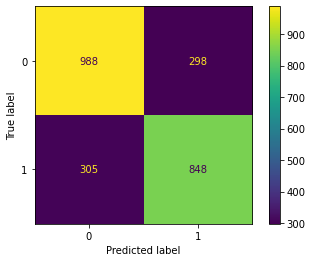

In [101]:
conmat = np.array(confusion_matrix(y_test, 
                                   randfor.predict(X_test_ss), 
                                   labels=[0, 1]))

print(classification_report(y_test,
                            randfor.predict(X_test_ss), 
                            target_names=['not_hot', 'hot']))

matrix_display = ConfusionMatrixDisplay(confusion_matrix=conmat, 
                                        display_labels=randfor.classes_)
matrix_display.plot();

### Random Forest Analysis
- this model is 75% accurate in predicting if a post is "hot"
- it is more more accurate in predicting if a post is "not hot" than predicting if a post is "hot"
- this model relied more heavily on the metadata collected for Reddit posts than the test in the Title of the Subreddit from which a post originated from. 
- it is marginally more accurate in predicting the class of a post compared to the Logistic Regression model. 
- it is interesting that this model differs from the Logistic Regression model in terms of the different features ability to predict the target class. 
- this model is not as "humanly" interpretable as the Logistic Regression model is, but it has slightly increased accuracy
- `score` was the most important feature for this model. This feature is most likely used deeper in a decision tree make data points in each child node more homogeneous

In [102]:
randfor_importance = pd.DataFrame(data=randfor.feature_importances_, 
             columns=['importance'], 
             index=X_train.columns).sort_values(by='importance', ascending=False)

In [103]:
randfor_importance.head(15)

,importance
score,0.331876
subreddit_subscribers,0.166989
length_time_seconds,0.104626
num_tokens,0.087820
num_crossposts,0.079114
is_self_True,0.035455
is_video_True,0.007572
like,0.006134
just,0.005499
make,0.005486


---
---

# Conclusion

**Model Comparison**
- Both the Logistic Regression model and the Random Forest model were more accurate at predicting the target class than the baseline
- The Random Forest model was only 2% more accurate than the Logistic Regression Model
- The Random Forest model gave more importance to the collected metadata and manufactured features 
- The Logistic Regression had larger coefficients for the Subreddit feature rather than individual words in the Reddit post Titles. 
- We were able to gain insight on certain features' ability to predict classification from the Logistic Regression model, and subsequently recommend to the client methods of estimating a posts probability of being "hot" based on certain features

# Recommendation

- We recommend using the Random Forest model we created to predict the classification of a Reddit post as being "hot"

These Features can be used to an certain extend to predict user interaction 


- Subreddits have a significant ability to predict the level of user interaction on a post
- The number of members of a Subreddit is not a good predictor for the level of user interaction on a post. 
- Reddit posts with opinionated or controversial topics often elicit a higher level of user interaction. 
- Keywords can be a good indication of user interaction, but this type of feature is less useful in predicting interaction level compared to the posts Subreddit origin
- Posts that are opinionated, controversial, political, or relevant to games/sports often have a high level of user interaction 